# Filtragem dos dados

In [15]:
from PIL import Image
import os

# Caminho para as pastas de imagens (tanto degradadas quanto clean)
degraded_dir = 'dataset/train/degraded'
clean_dir = 'dataset/train/clean'

# Lista para armazenar imagens com menos de 3 canais
non_rgb_images = []

# Função para verificar o número de canais de uma imagem
def check_image_channels(image_path):
    image = Image.open(image_path)
    # Verificar se a imagem é RGB
    if image.mode != 'RGB':
        return image_path, image.mode  # Retorna o caminho e o modo (por exemplo, 'L' para grayscale)
    return None

# Verificar e armazenar as imagens não RGB no diretório 'clean'
for filename in os.listdir(clean_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(clean_dir, filename)
        result = check_image_channels(image_path)
        if result:
            non_rgb_images.append(filename)

In [16]:
import matplotlib.pyplot as plt

In [17]:
# Excluir as imagens que não possuem 3 canais em ambas as pastas
for filename in non_rgb_images:
    # Caminhos das imagens nas pastas 'degraded' e 'clean'
    degraded_image_path = os.path.join(degraded_dir, filename)
    clean_image_path = os.path.join(clean_dir, filename)

    # Verificar e excluir as imagens
    if os.path.exists(degraded_image_path):
        os.remove(degraded_image_path)
        print(f"Deletado: {degraded_image_path}")

    if os.path.exists(clean_image_path):
        os.remove(clean_image_path)
        print(f"Deletado: {clean_image_path}")

# Exibir o total de imagens deletadas
print(f"Total de imagens deletadas: {len(non_rgb_images)}")

Total de imagens deletadas: 0


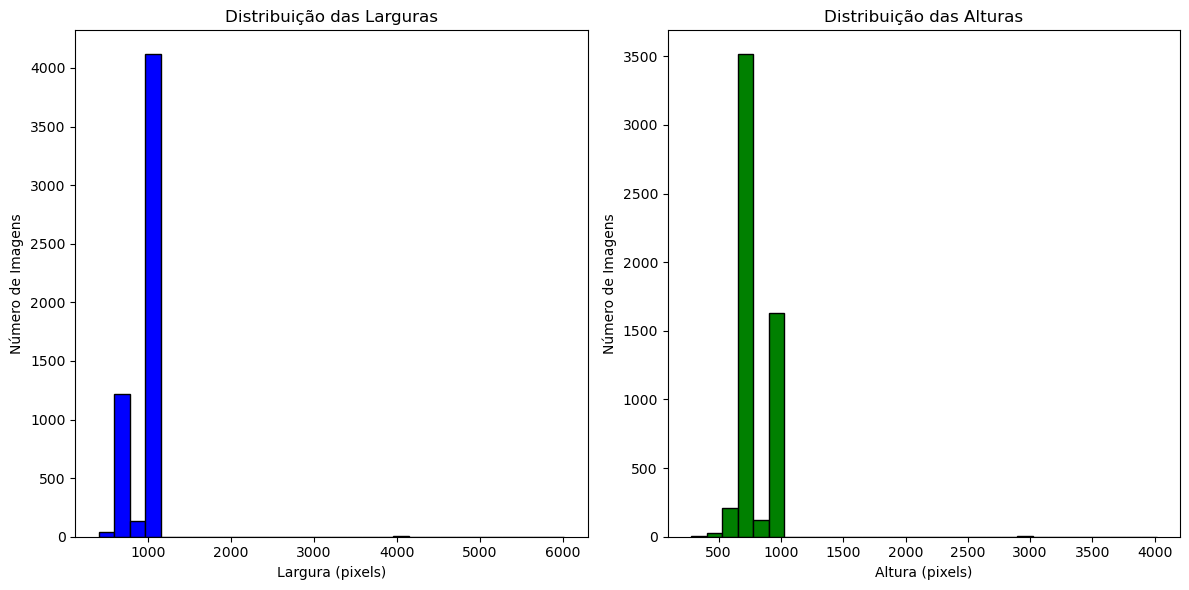

In [19]:
from PIL import Image
import os
import matplotlib.pyplot as plt

# Caminho para o diretório das imagens
image_dir = 'dataset/train/clean'

# Listas para armazenar larguras e alturas
widths = []
heights = []

# Percorrer todas as imagens e obter suas dimensões
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(image_dir, filename)
        with Image.open(image_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

# Plotar a distribuição das larguras e alturas
plt.figure(figsize=(12, 6))

# Plot das larguras
plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='blue', edgecolor='black')
plt.title('Distribuição das Larguras')
plt.xlabel('Largura (pixels)')
plt.ylabel('Número de Imagens')

# Plot das alturas
plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='green', edgecolor='black')
plt.title('Distribuição das Alturas')
plt.xlabel('Altura (pixels)')
plt.ylabel('Número de Imagens')

plt.tight_layout()
plt.show()

# Degradação

In [18]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import os
import matplotlib.pyplot as plt

# Função para adicionar ruído gaussiano
def add_gaussian_noise(image):
    row, col, ch = image.shape
    mean = 0
    sigma = 25  # Pode ajustar este valor para mais ou menos ruído
    gauss = np.random.normal(mean, sigma, (row, col, ch)).reshape(row, col, ch)
    noisy_image = image + gauss
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

# Função para desbotar as cores
def fade_colors(image):
    enhancer = ImageEnhance.Color(image)
    return enhancer.enhance(0.05)  # Diminui a saturação

# Função para aplicar desfoque
def add_blur(image):
    return image.filter(ImageFilter.GaussianBlur(radius=1))  # Ajuste o valor do radius

# Função principal para aplicar degradações
def degrade_image(image_path):
    image = Image.open(image_path)
    image_cv = cv2.imread(image_path)

    # Aplicar várias degradações
    noisy_image = add_gaussian_noise(image_cv)  # Ruído
    noisy_image_pil = Image.fromarray(noisy_image)
    faded_image = fade_colors(noisy_image_pil)  # Desbotar cores
    blurred_image = add_blur(faded_image)  # Desfoque

    return image, blurred_image

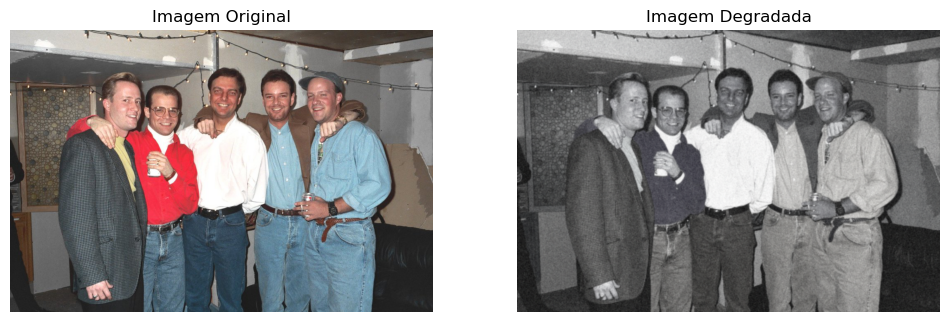

In [8]:
# Testar com uma imagem específica
image_path = 'C:/Users/Demop/OneDrive/Documentos/GitHub/gan/dataset/train/clean/0a1a43775bc3d544.jpg'

# Obter a imagem original e a degradada
original_image, degraded_image = degrade_image(image_path)

# Exibir a imagem original e a imagem degradada
plt.figure(figsize=(12, 6))

# Imagem original
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Imagem Original')
plt.axis('off')

# Imagem degradada
plt.subplot(1, 2, 2)
plt.imshow(degraded_image)
plt.title('Imagem Degradada')
plt.axis('off')

plt.show()


# Aplicando degradação

In [10]:
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, degraded_dir, clean_dir, transform=None):
        self.degraded_dir = degraded_dir
        self.clean_dir = clean_dir
        self.degraded_images = sorted(os.listdir(degraded_dir))
        self.clean_images = sorted(os.listdir(clean_dir))
        self.transform = transform

    def __len__(self):
        return len(self.degraded_images)

    def __getitem__(self, idx):
        # Abrir a imagem degradada
        degraded_image = Image.open(os.path.join(self.degraded_dir, self.degraded_images[idx]))
        # Converter para RGB se a imagem for grayscale
        if degraded_image.mode != 'RGB':
            degraded_image = degraded_image.convert('RGB')

        # Abrir a imagem limpa
        clean_image = Image.open(os.path.join(self.clean_dir, self.clean_images[idx]))
        # Converter para RGB se a imagem for grayscale
        if clean_image.mode != 'RGB':
            clean_image = clean_image.convert('RGB')

        # Aplicar as transformações
        if self.transform:
            degraded_image = self.transform(degraded_image)
            clean_image = self.transform(clean_image)

        return degraded_image, clean_image

# Transformação para as imagens (redimensionar e converter para tensor)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Caminhos para as pastas de imagens
degraded_dir = 'dataset/train/degraded'
clean_dir = 'dataset/train/clean'

# Criar dataset e DataLoader
train_dataset = ImageDataset(degraded_dir=degraded_dir, clean_dir=clean_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Criando o modelo

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

# Definindo o Dataset para carregar as imagens degradadas e limpas
class ImageDataset(Dataset):
    def __init__(self, degraded_dir, clean_dir, transform=None):
        self.degraded_dir = degraded_dir
        self.clean_dir = clean_dir
        self.degraded_images = sorted(os.listdir(degraded_dir))
        self.clean_images = sorted(os.listdir(clean_dir))
        self.transform = transform

    def __len__(self):
        return len(self.degraded_images)

    def __getitem__(self, idx):
        degraded_image = Image.open(os.path.join(self.degraded_dir, self.degraded_images[idx]))
        clean_image = Image.open(os.path.join(self.clean_dir, self.clean_images[idx]))

        if self.transform:
            degraded_image = self.transform(degraded_image)
            clean_image = self.transform(clean_image)

        return degraded_image, clean_image

# Transformação das imagens (redimensionar e converter para tensor)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Caminhos para as pastas de imagens
degraded_dir = 'dataset/train/degraded'
clean_dir = 'dataset/train/clean'

# Criar dataset e DataLoader
train_dataset = ImageDataset(degraded_dir=degraded_dir, clean_dir=clean_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


# Generator

In [12]:
import torch
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # Encoder: camada de downsampling
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
            # Continue para adicionar mais camadas de downsampling
        )

        # Decoder: camada de upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, img_degraded, img_clean):
        img_input = torch.cat((img_degraded, img_clean), 1)  # Concatenar imagens degradadas e clean
        return self.model(img_input)


# Training Process

In [14]:
import torch.optim as optim

# Inicializar o gerador e o discriminador
generator = UNetGenerator()
discriminator = Discriminator()

# Critério de perda
adversarial_loss = nn.BCELoss()
pixelwise_loss = nn.L1Loss()

# Otimizadores
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loop de treinamento
num_epochs = 100
for epoch in range(num_epochs):
    for i, (imgs_degraded, imgs_clean) in enumerate(train_loader):
        # Rótulos reais e falsos
        valid = torch.ones((imgs_degraded.size(0), 1), requires_grad=False)
        fake = torch.zeros((imgs_degraded.size(0), 1), requires_grad=False)

        # ------------------
        # Treinar o Gerador
        # ------------------
        optimizer_G.zero_grad()

        # Gera a imagem restaurada
        gen_imgs = generator(imgs_degraded)

        # Perda adversarial (tentando enganar o discriminador)
        # O discriminador retorna um mapa de decisão, então usamos a média
        g_loss = adversarial_loss(torch.mean(discriminator(gen_imgs, imgs_clean)), valid) + pixelwise_loss(gen_imgs, imgs_clean)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        # Treinar o Discriminador
        # ---------------------
        optimizer_D.zero_grad()

        # Perda real (imagens verdadeiras)
        real_loss = adversarial_loss(torch.mean(discriminator(imgs_degraded, imgs_clean)), valid)

        # Perda falsa (imagens geradas pelo gerador)
        fake_loss = adversarial_loss(torch.mean(discriminator(imgs_degraded, gen_imgs.detach())), fake)

        # Média das perdas
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()


    print(f"Epoch [{epoch}/{num_epochs}] | Generator Loss: {g_loss.item()} | Discriminator Loss: {d_loss.item()}")

ValueError: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.

In [17]:
len(non_rgb_images)

221